O seguinte notebook tem como objetivo aplicar uma análise descritiva, teste de hipóteses e também análise de sobrevivência aplicada a um conjunto de dados relacionado à evasão escolar no curso de Bacharel em Estatística da UFRGS. Os dados foram digitalizados do TCC de referência utilizado: https://lume.ufrgs.br/bitstream/handle/10183/198131/000188649.pdf?sequence=1

"A evasão é um problema que merece ser estudado com profundidade, tanto pelo aspecto pedagógico envolvido, como econômico e social. Alguns cursos superiores da UFRGS são caracterizados como cursos onde a evasão é grande e preocupante. Diversas causas, identificadas através de pesquisas realizadas pela Universidade, são apontadas: necessidade de trabalhar, incompatibilidade de horário de trabalho e estudo, curso não correspondeu às expectativas, etc."

"Dentre os cursos em que a evasão é preocupante, encontra-se o Curso de Bacharelado em Estatística. Assim, este trabalho visa analisar o tempo de permanência dos alunos no curso, até a sua evasão, permitindo, desta maneira, que seja estudado um exemplo prático na área educacional com aplicação da técnica estatística Análise de Sobrevivência, utilizando os alunos do Curso de Estatística como população de estudo."

- $H_o$: As médias das idades dos dois grupos de alunos são iguais.
- $H_a$: As médias das idades dos dois grupos de alunos são diferentes.

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, NelsonAalenFitter

pd.options.display.float_format = "{:,.2f}".format

Primeiramente vou fazer a análise descritiva dos dados completos e além disso a análise exploratória, após isso a separação das amostras para responder às hipóteses juntamente com a análise de sobrevivência.
A hipótese é, dos alunos censurados, isto é, dos evasivos, existe alguma diferença nas médias das idades dos gêneros. 

In [2]:
df = pd.read_csv("../dataset/data.csv")

df.columns = ['ingresso', 'genero', 'idade', 'n_aprovacoes', 'n_reprovacoes', 'tempo', 'censura', 'ano_ingresso']

dfs = df[df["censura"] == 1]
gen1 = dfs.loc[dfs["genero"] == 1, "idade"]
gen2 = dfs.loc[dfs["genero"] == 2, "idade"]

### 1.0. Análise Descritiva

In [3]:
aux = df.describe().T
aux["skew"] = df.apply(lambda x: x.skew())
aux["kurtosis"] = df.apply(lambda x: x.kurtosis())
aux

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
ingresso,150.00,1.41,1.02,1.00,1.00,1.00,1.00,7.00,3.46,13.92
genero,150.00,1.31,0.47,1.00,1.00,1.00,2.00,2.00,0.81,-1.36
idade,150.00,22.85,5.58,17.00,19.00,21.00,26.00,43.00,1.46,1.97
n_aprovacoes,150.00,2.04,1.85,0.00,0.00,2.00,3.00,7.00,0.55,-0.70
n_reprovacoes,150.00,1.90,1.51,0.00,1.00,2.00,3.00,6.00,0.77,0.03
tempo,150.00,6.09,4.44,1.00,3.00,4.50,8.00,22.00,1.42,1.71
censura,150.00,0.69,0.46,0.00,0.00,1.00,1.00,1.00,-0.85,-1.30
ano_ingresso,150.00,89.85,3.26,85.00,87.00,90.00,93.00,95.00,0.01,-1.31


In [16]:
df["ingresso"].value_counts()

ingresso
1    118
2     16
3     11
7      2
6      1
4      1
5      1
Name: count, dtype: int64

In [4]:
dfs[["genero", "idade"]].groupby("genero").agg(
    mean=("idade", "mean"),
    std=("idade", "std"),
    n=("idade", "count")
)

,mean,std,n
genero,,,
1,24.08,5.91,73
2,20.29,3.67,31


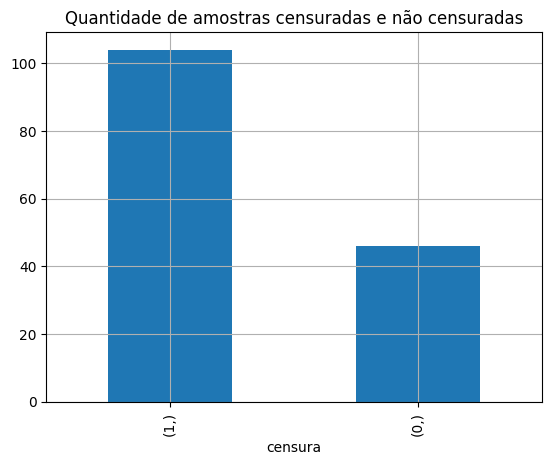

In [4]:
ax = df[["censura"]].value_counts().plot(kind="bar");
ax.grid(2);
ax.set_title("Quantidade de amostras censuradas e não censuradas");

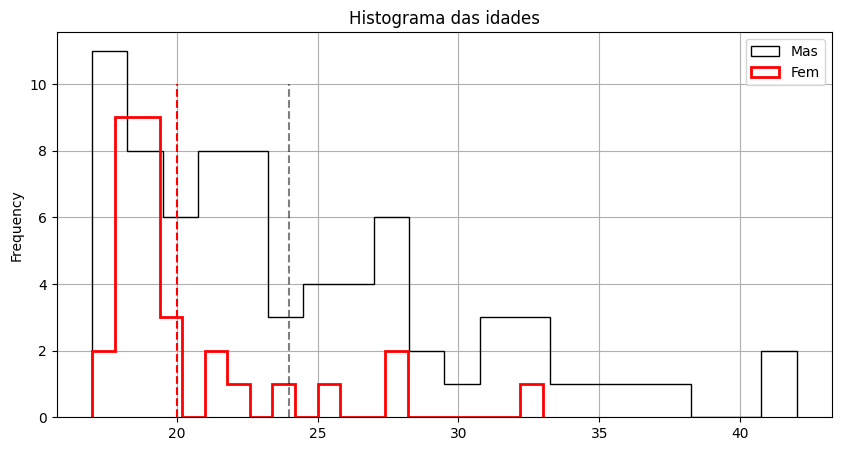

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
gen1.plot(kind="hist", histtype="step", label="Mas", color="k", legend=True, grid=2, bins=20)
ax = gen2.plot(kind="hist", histtype="step", label="Fem", color="r", legend=True, grid=2, linewidth=2, bins=20);
ax.vlines(int(gen1.mean()), ymin=0, ymax=10, color="k", linestyles="--", alpha=0.5)
ax.vlines(int(gen2.mean()), ymin=0, ymax=10, color="r", linestyles="--")

ax.set_title("Histograma das idades");

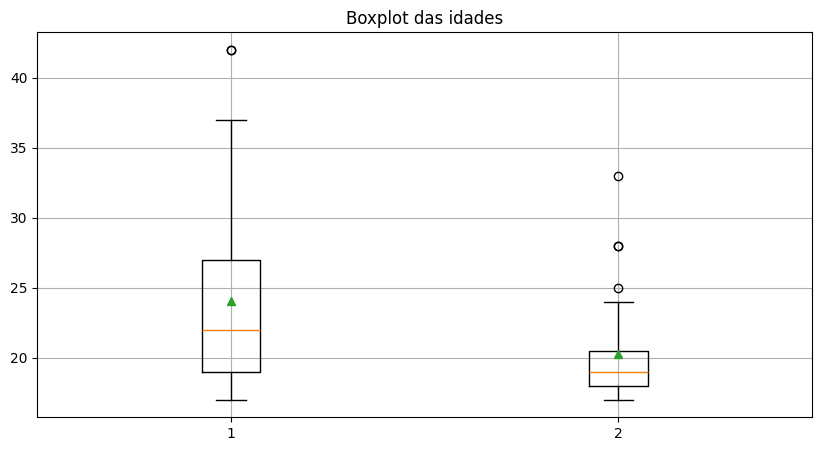

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.boxplot([gen1, gen2], label=["1", "2"], showmeans=True);
ax.grid(True);
ax.set_title("Boxplot das idades");

Pontos Interessantes:

- A média da censura é aproximadamente 70%, isso caracteriza um desbalanceamento de classes.
- Existem ingressantes no curso de estatística menores de 18 anos.
- Mais de 50% dos alunos intrevistados entraram por meio do vestibular tradicional (ingresso = 1).
- Intervalo de estudantes em 10 anos de ingresso no curso.


### 2.0. Análise Exploratória

In [46]:
hist_params = {
    "bins": 10,
    "legend": True,
    "histtype": "step"
}

#### 2.1. Análise Univariada

É notavel que, amostras nos anos finais de estudo a censura não vai ser identificada devido que o evento de interesse ainda não aconteceu, isso é notável pelo histograma, pessoas que entraram no curso mais recentemente ainda não teve o tempo de maturação para evadir. 

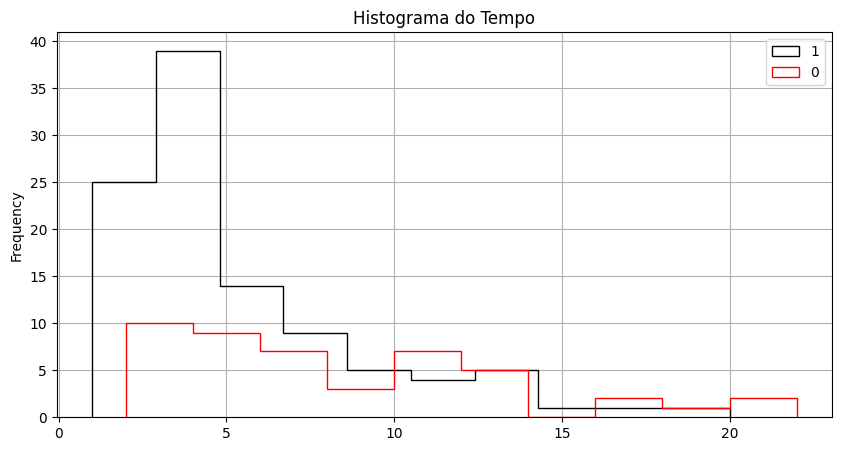

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[df["censura"] == 1, "tempo"].plot(kind="hist", label="1", color="k", **hist_params)
ax = df.loc[df["censura"] == 0, "tempo"].plot(kind="hist", label="0", color="r", **hist_params);
ax.set_title("Histograma do Tempo");
ax.grid(2);

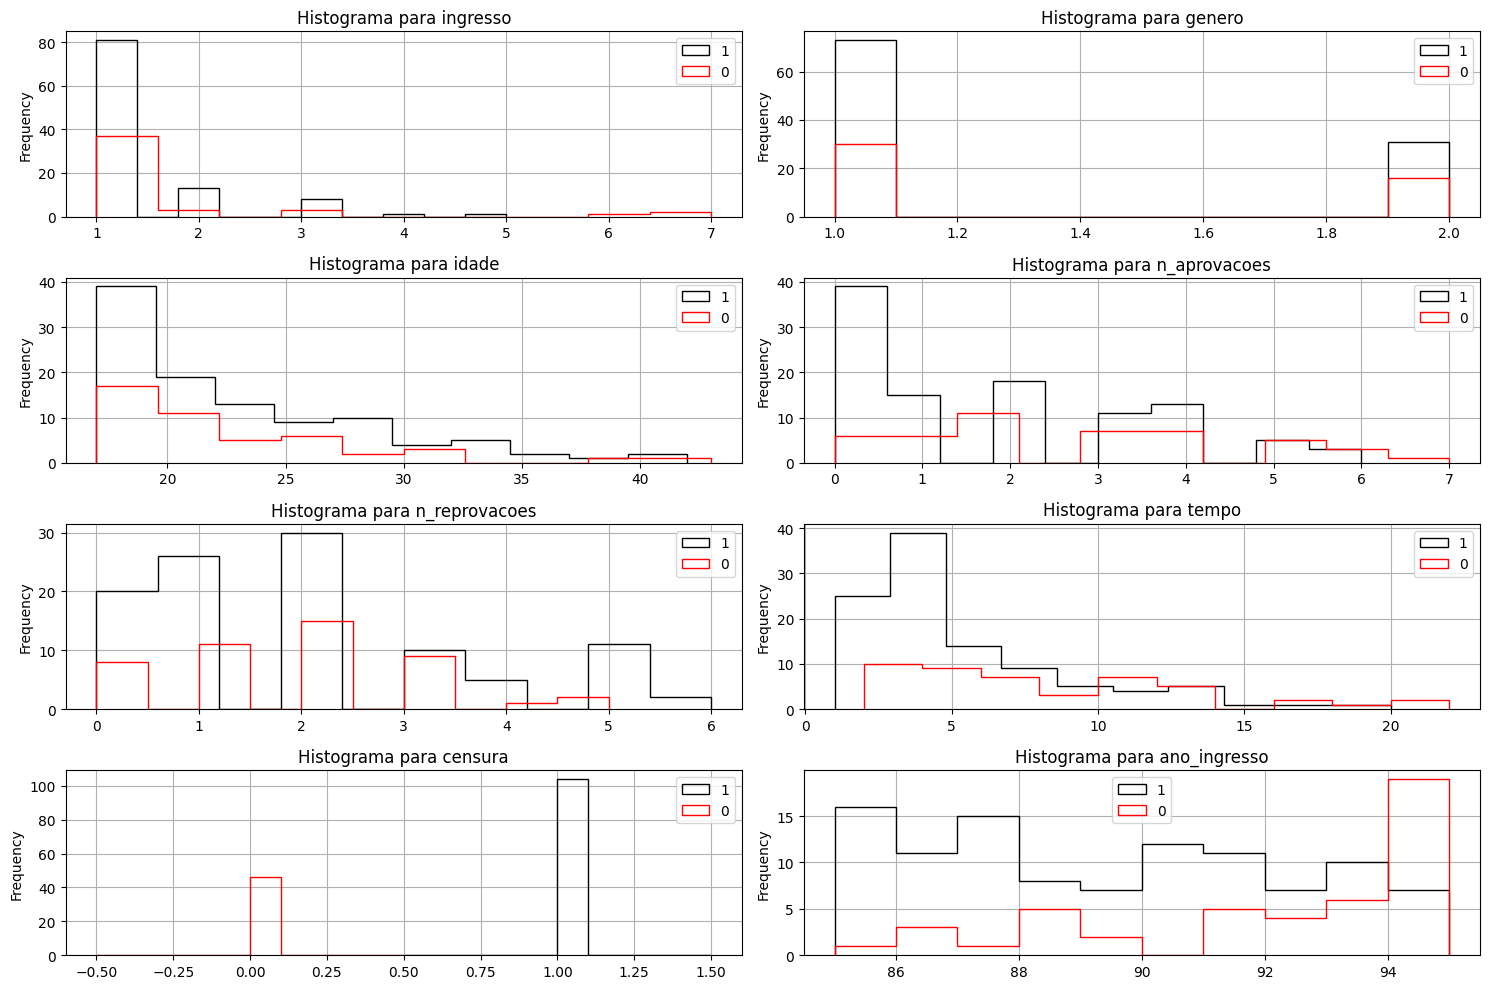

In [48]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))
ax = ax.flatten()

for axi, coli in zip(
    ax, df.columns
):
    df.loc[df["censura"] == 1, coli].plot(kind="hist", label="1", color="k", ax=axi, **hist_params)
    df.loc[df["censura"] == 0, coli].plot(kind="hist", label="0", color="r", ax=axi, **hist_params)

    axi.set_title(f"Histograma para {coli}")
    axi.grid(2)

plt.tight_layout()

#### 2.2. Análise Bivariada

##### 2.2.1. Redução da Dimensionalidade

In [17]:
X = df.drop(columns=["censura"], axis=1)

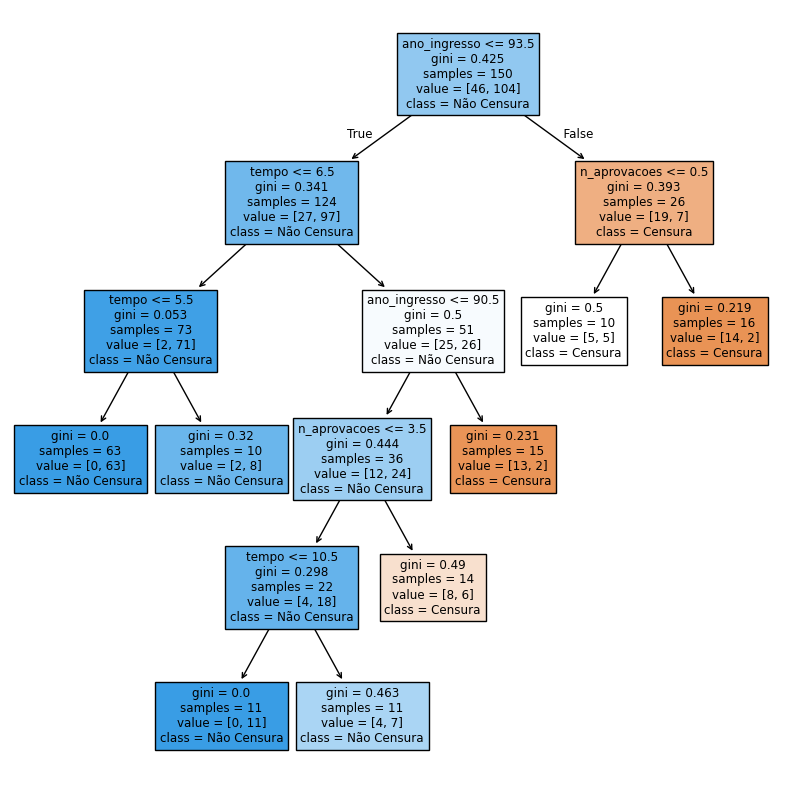

In [83]:
dtc = DecisionTreeClassifier(
    min_samples_leaf=10
)

dtc.fit(
    X=X,
    y=df["censura"]
)

fig, ax = plt.subplots(figsize=(10,10))
plot_tree(
    dtc,
    class_names=df["censura"].apply(lambda x: "Censura" if x else "Não Censura"),
    feature_names=X.columns,
    filled=True
);

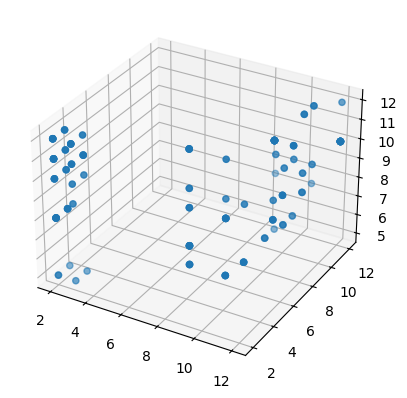

In [96]:
dtc = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=3,
    min_samples_leaf=10
)

dtc.fit(
    X=X,
    y=df["censura"]
)

lf = pd.DataFrame(dtc.apply(X))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(lf[0], lf[1], lf[2]);

#### 2.3. Análise Multivariada

Uma pequena análise das correlações lineares entre pares de variáveis é possível notar que a censura tem correlação negativa com quase todas as variáveis. 

In [91]:
df.corr()

,ingresso,genero,idade,n_aprovacoes,n_reprovacoes,tempo,censura,ano_ingresso
ingresso,1.00,0.05,0.09,-0.03,-0.14,0.01,-0.10,-0.04
genero,0.05,1.00,-0.30,0.06,0.04,-0.00,-0.05,0.01
idade,0.09,-0.30,1.00,-0.30,-0.04,-0.01,0.03,-0.01
n_aprovacoes,-0.03,0.06,-0.30,1.00,-0.34,0.36,-0.26,-0.05
n_reprovacoes,-0.14,0.04,-0.04,-0.34,1.00,-0.15,0.05,0.05
tempo,0.01,-0.00,-0.01,0.36,-0.15,1.00,-0.31,-0.32
censura,-0.10,-0.05,0.03,-0.26,0.05,-0.31,1.00,-0.41
ano_ingresso,-0.04,0.01,-0.01,-0.05,0.05,-0.32,-0.41,1.00
